
# Forest Cover Type Prediction
**Author:** MT2025065

## Objective
To analyze the Forest Cover Type dataset, perform exploratory data analysis (EDA), preprocess the data, and build machine learning models to predict the forest cover type.



In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")



Libraries loaded successfully.


# 1 Data Processing

## 1.1 Exploratory Data Analysis (EDA)

### 1.1.1 Initial Analysis

Dataset Dimensions

In [2]:

df = pd.read_csv('covtype.csv')
print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


Count of Numerical and Categorical Features

In [3]:
target_col = "Cover_Type"
features = df.drop(columns=[target_col])

numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = features.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numerical Features (", len(numerical_features), "):", numerical_features)
print("Categorical Features (", len(categorical_features), "):", categorical_features)


Numerical Features ( 54 ): ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
Categorical Features ( 0 ): []


### 1.1.2 Target Distribution
Analyzing target distribution helps determine whether the dataset is balanced across cover types.  
Imbalanced classes may require special handling, but this distribution shows moderate variation.  
Understanding class proportions is important for fair model evaluation and stratified splitting.


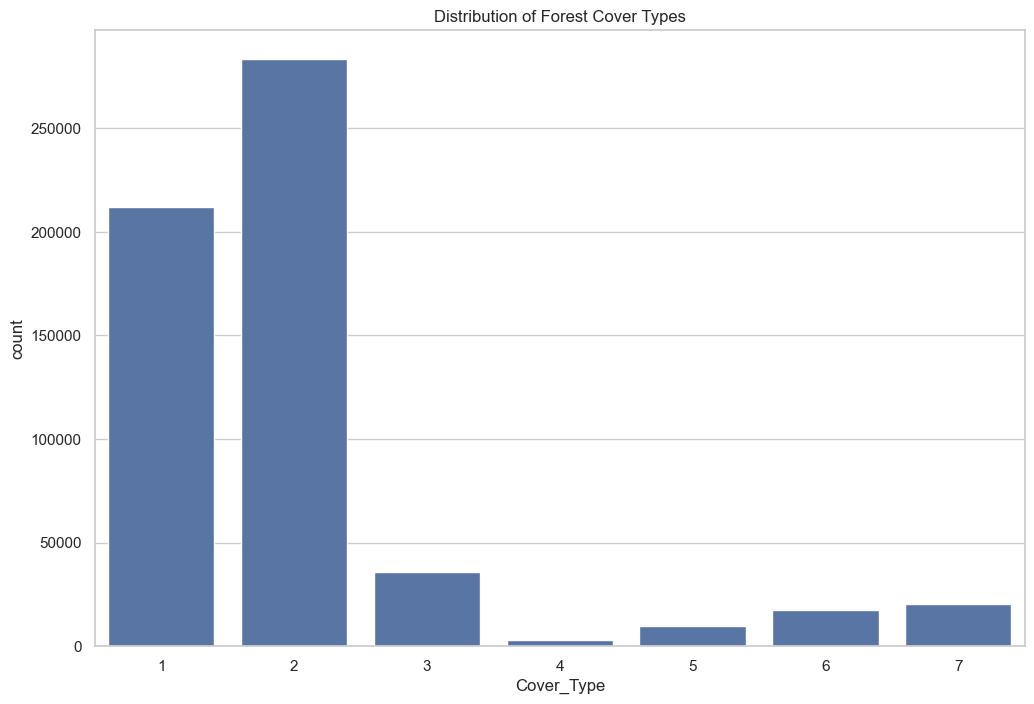

Cover_Type
2    0.487599
1    0.364605
3    0.061537
7    0.035300
6    0.029891
5    0.016339
4    0.004728
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Cover_Type', data=df)
plt.title('Distribution of Forest Cover Types')
plt.show()

print(df['Cover_Type'].value_counts(normalize=True))

### 1.1.3 Numerical Feature Distributions
Visualizing histograms helps identify skewed features and natural variability across environmental attributes.  
This aids in choosing appropriate scaling and transformation methods for different models.  
Understanding feature shapes also helps highlight potential outliers and nonlinear patterns.Below is a diagram consisting Histograms of first 10 Numerical Features


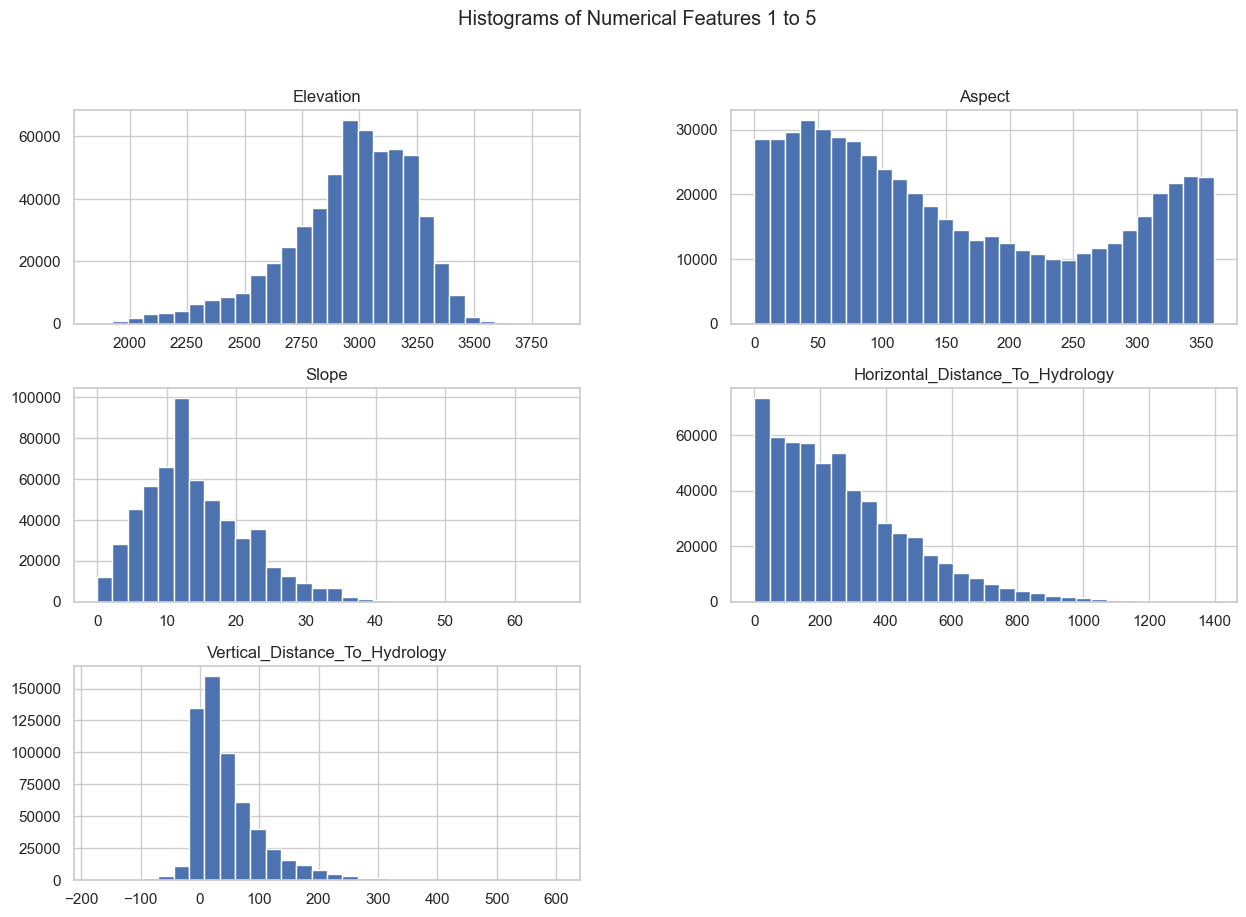

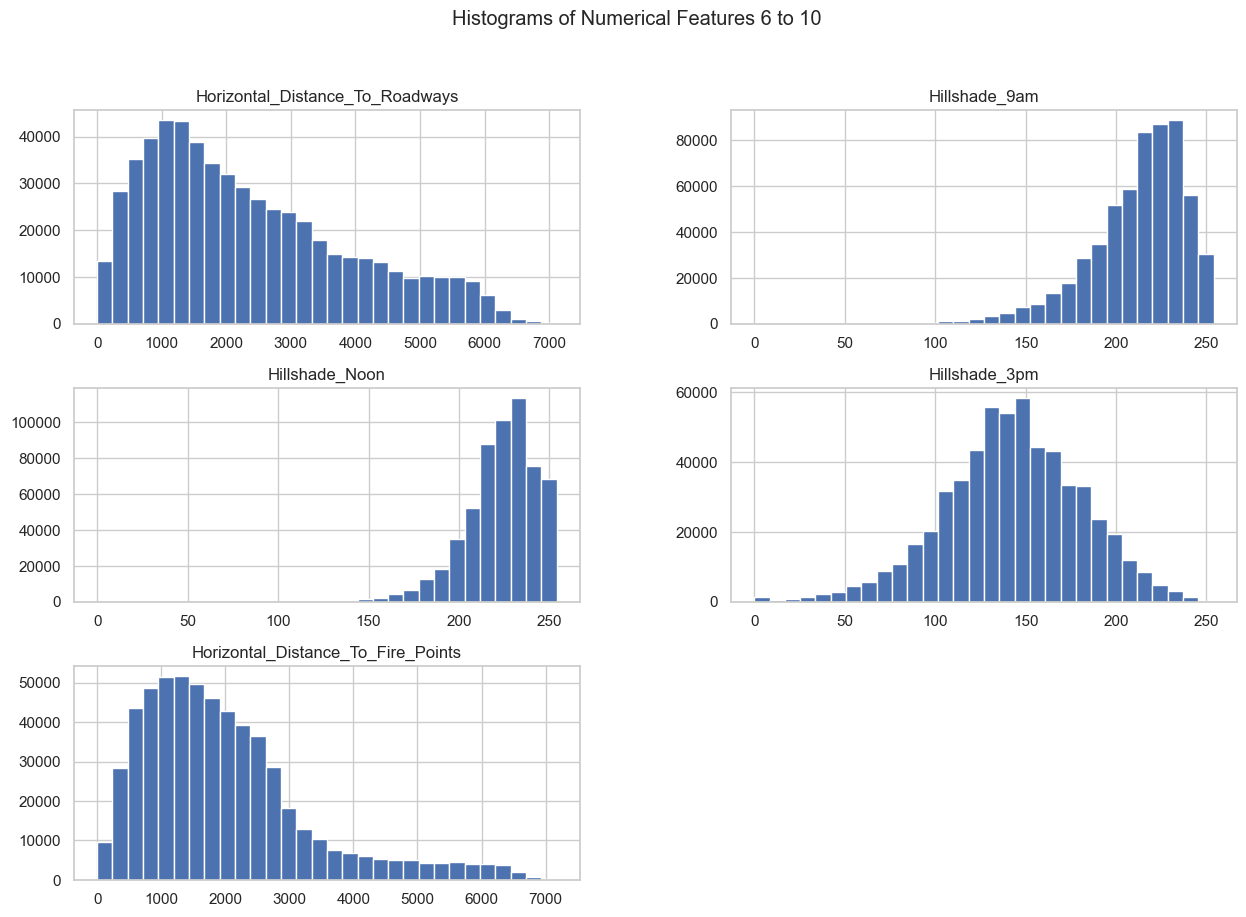

In [9]:
import matplotlib.pyplot as plt

numerical_cols = numerical_cols[:10]

for i in range(0, 10, 5):
    subset = numerical_cols[i:i+5]
    df[subset].hist(figsize=(15, 10), bins=30)
    plt.suptitle(f'Histograms of Numerical Features {i+1} to {i+5}')
    plt.show()


### 1.1.4 Outlier Handling
The outlier analysis shows that extreme values exist across several numerical features, but they represent natural environmental variation rather than noise.  
Instead of removing or heavily transforming these values, RobustScaler is preferred because it reduces the influence of outliers while preserving all data.  
This makes it more suitable than log transformation or row-removal methods for models like Logistic Regression, SVM, and Neural Networks, which are sensitive to feature scale.


In [ ]:
import numpy as np
import pandas as pd 
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler

numeric_cols = df.columns[:10]
outlier_summary = []

for col in numeric_cols:
    series = df[col].dropna()
    z_scores = zscore(series)
    z_out_count = int((np.abs(z_scores) > 3).sum())
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    iqr_out_count = int(((series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))).sum())
    skewness = float(series.skew())
    outlier_summary.append({
        'feature': col,
        'z_outliers': z_out_count,
        'iqr_outliers': iqr_out_count,
        'skewness': skewness
    })

out_df = pd.DataFrame(outlier_summary).set_index('feature')
display(out_df)

def remove_zscore(df_in, cols, thresh=3):
    df_out = df_in.copy()
    mask = np.ones(len(df_out), dtype=bool)
    for c in cols:
        zs = zscore(df_out[c].fillna(df_out[c].median()))
        mask = mask & (np.abs(zs) <= thresh)
    return df_out[mask]

def remove_iqr(df_in, cols, factor=1.5):
    df_out = df_in.copy()
    mask = np.ones(len(df_out), dtype=bool)
    for c in cols:
        s = df_out[c]
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        mask = mask & (s >= (q1 - factor*iqr)) & (s <= (q3 + factor*iqr))
    return df_out[mask]

def winsorize_cap(df_in, cols, lower_q=0.01, upper_q=0.99):
    df_out = df_in.copy() 
    for c in cols:
        low = df_out[c].quantile(lower_q)
        high = df_out[c].quantile(upper_q)
        df_out[c] = np.where(df_out[c] < low, low, df_out[c])
        df_out[c] = np.where(df_out[c] > high, high, df_out[c])
    return df_out

def log_transform_if_possible(df_in, cols):
    df_out = df_in.copy()
    for c in cols:
        if df_out[c].min() >= 0:
            df_out[c] = np.log1p(df_out[c])
    return df_out

original_df = df.copy()
z_removed_df = remove_zscore(df, numeric_cols)
iqr_removed_df = remove_iqr(df, numeric_cols)
winsor_df = winsorize_cap(df, numeric_cols)
log_df = log_transform_if_possible(df, numeric_cols)

rs = RobustScaler()
robust_scaled_df = df.copy()
robust_scaled_df[numeric_cols] = rs.fit_transform(df[numeric_cols])
print("\n Many features are highly skewed, IQR outlier counts are much larger than Z-score outliers.")
print("\n This signifies the usage of Robust Scaling because of its robustness to outliers.")
print("\n Many IQR outlier counts make us use log transformation.")

,z_outliers,iqr_outliers,skewness
feature,,,
Elevation,5832,15569,-0.817596
Aspect,0,0,0.402628
Slope,4074,15316,0.789273
Horizontal_Distance_To_Hydrology,7073,14557,1.140437
Vertical_Distance_To_Hydrology,10059,31463,1.790250
Horizontal_Distance_To_Roadways,33,669,0.713679
Hillshade_9am,7516,17433,-1.181147
Hillshade_Noon,7082,15672,-1.063056
Hillshade_3pm,3042,7832,-0.277053



 Many features are highly skewed, IQR outlier counts are much larger than Z-score outliers.

 This signifies the usage of Robust Scaling because of its robustness to outliers.

 Many IQR outlier counts make us use log transformation.



### 1.1.5 Feature Correlations
We visualize the correlation matrix for the first 10 numerical features (which are continuous) to understand relationships between variables.
Also, we'll visualize the correlation matrix for the first 10 numerical features wit respect to the target features, to see relationships between them.

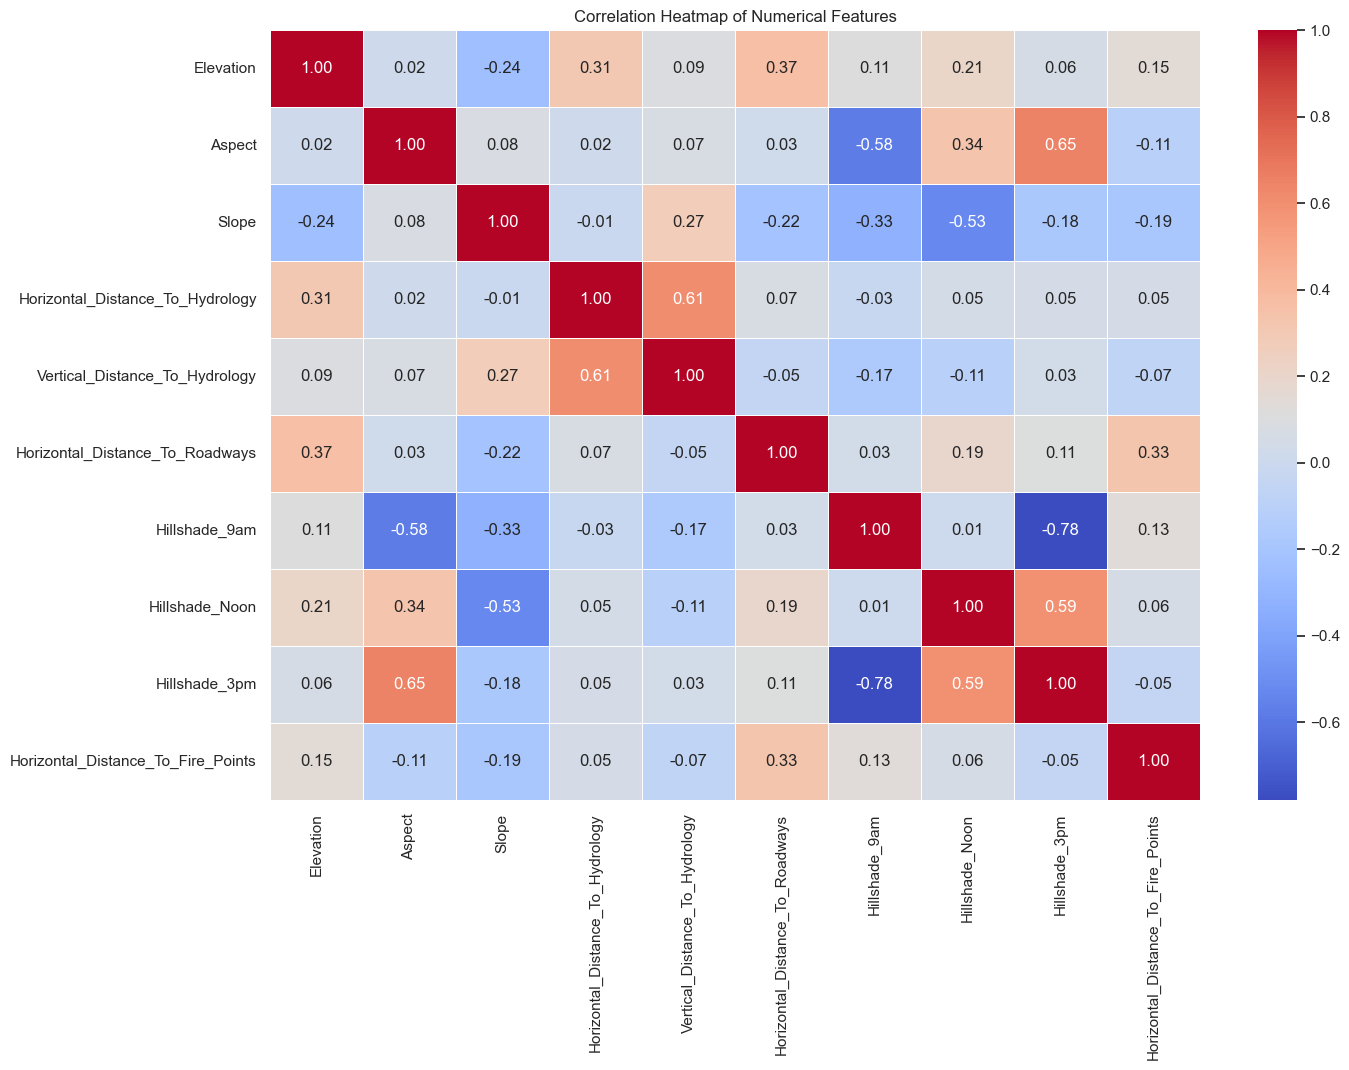

Slope                                 0.148285
Vertical_Distance_To_Hydrology        0.081664
Aspect                                0.017080
Horizontal_Distance_To_Hydrology     -0.020317
Hillshade_9am                        -0.035415
Hillshade_3pm                        -0.048290
Hillshade_Noon                       -0.096426
Horizontal_Distance_To_Fire_Points   -0.108936
Horizontal_Distance_To_Roadways      -0.153450
Elevation                            -0.269554
Name: Cover_Type, dtype: float64

In [10]:
numerical_cols = df.columns[:10]

plt.figure(figsize=(15, 10))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

target_corr = df[numerical_cols].join(df['Cover_Type']).corr()['Cover_Type'] \
                                 .drop('Cover_Type') \
                                 .sort_values(ascending=False)

display(target_corr)


Correlation of Numerical Features with Target

### 1.1.6 Target value Analysis
Boxplots grouped by cover type reveal how feature distributions differ between forest classes.  
Features that show visible separation are good candidates for predictive modeling.  
This analysis highlights which environmental factors most influence cover type classification.


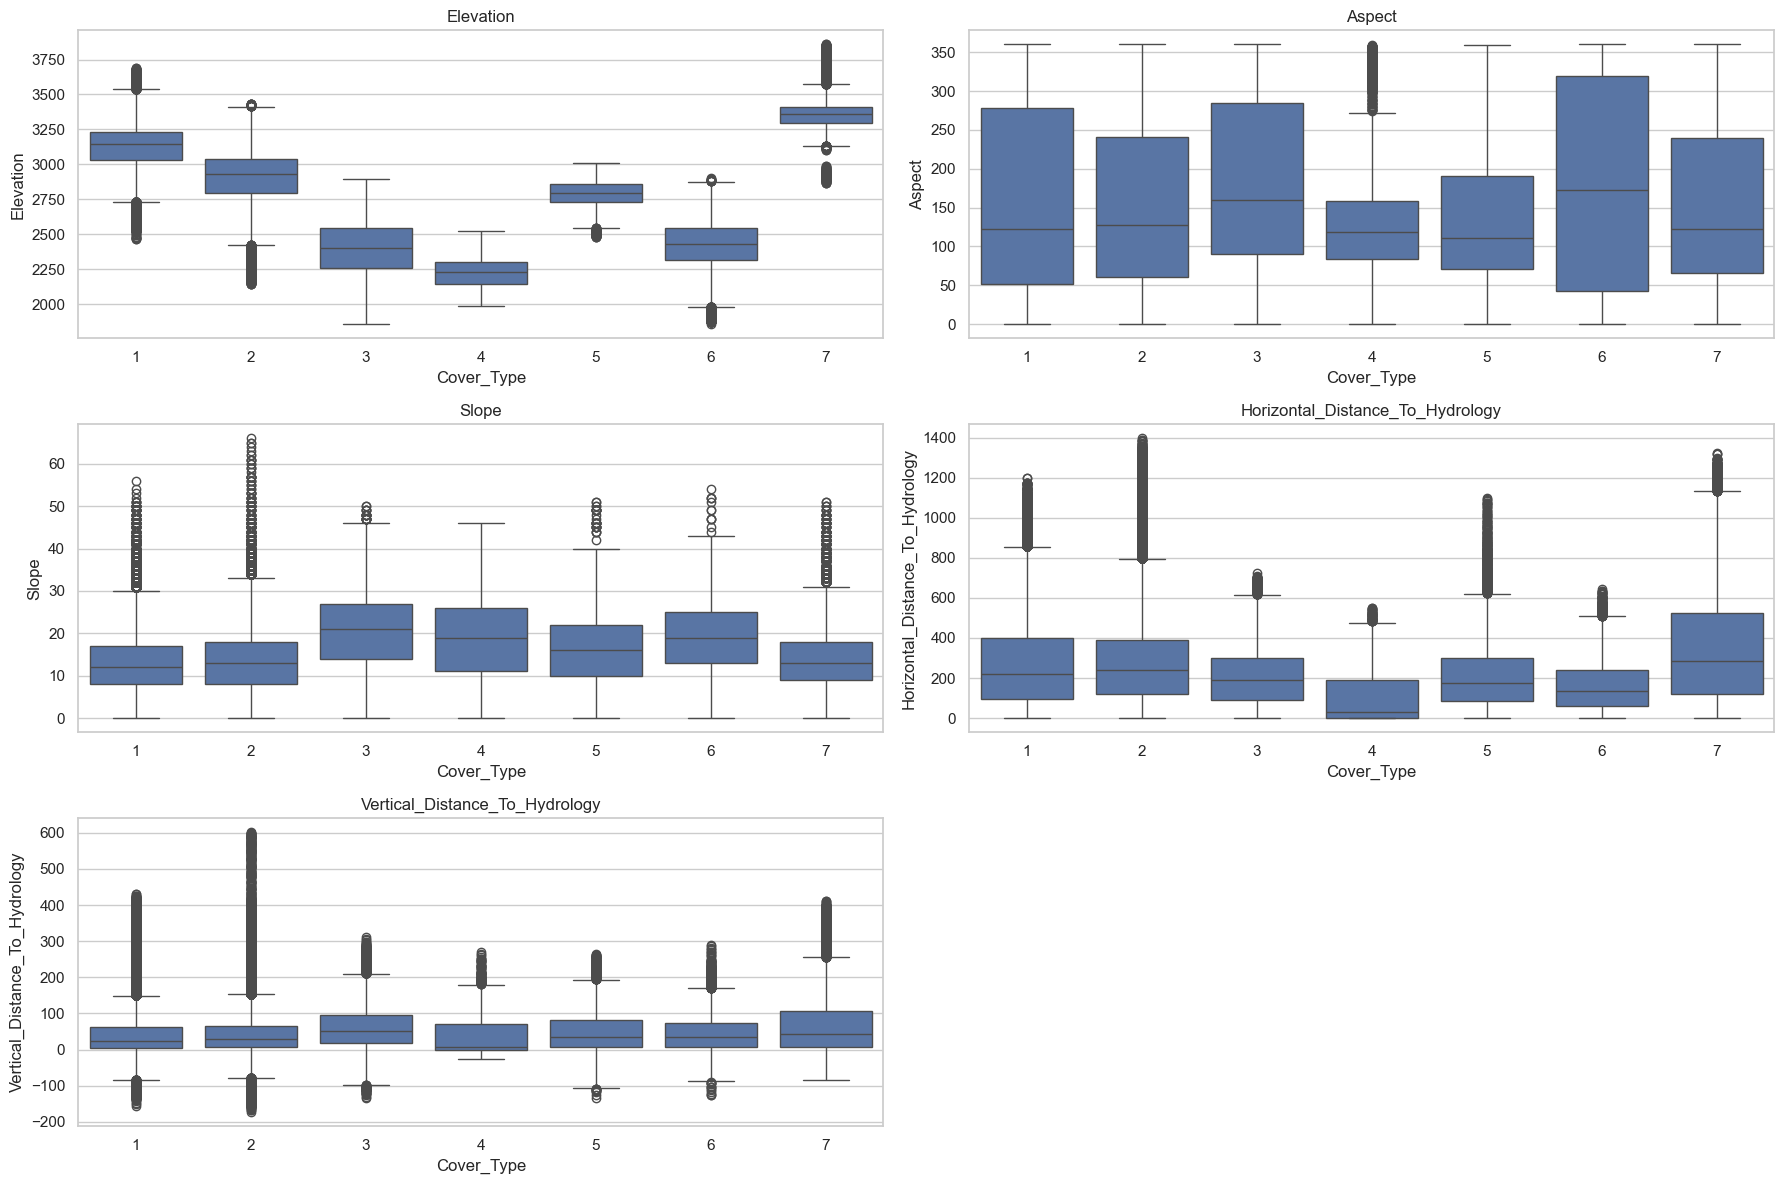

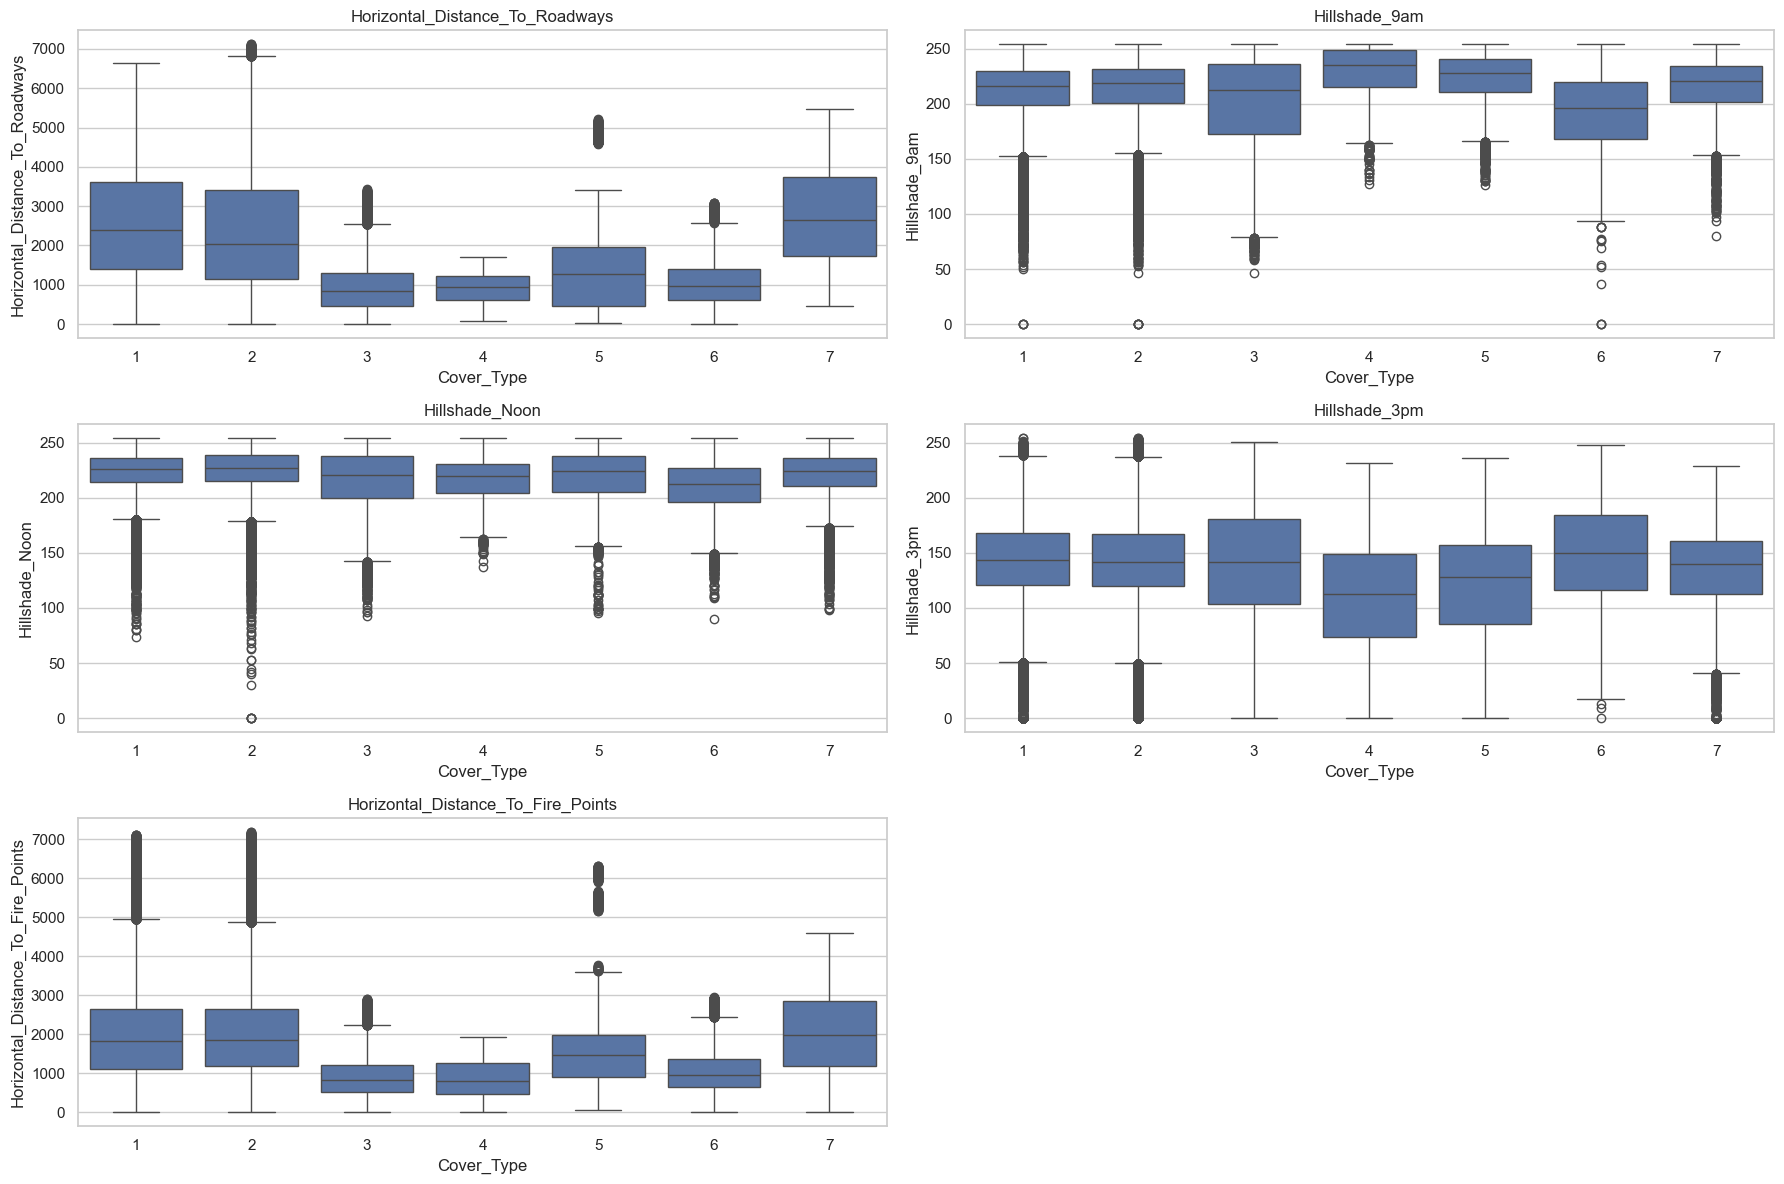

In [10]:
numerical_cols = df.columns[:10]

for i in range(0, 10, 5):
    subset = numerical_cols[i:i+5]
    plt.figure(figsize=(18, 12))
    for j, col in enumerate(subset, 1):
        plt.subplot(3, 2, j)
        sns.boxplot(x=df["Cover_Type"], y=df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()


## 1.2. Data Preprocessing
We split the data into features (X) and target (y), and then into training and testing sets. We use a stratified split to maintain the class distribution.



### 1.2.1 Data Loading and Exploration
We examine the data types and check for null values to assess data quality. Duplicate rows are identified and removed to prevent the model from memorizing identical samples, ensuring unbiased training.

In [ ]:
print("--- Info ---")
df.info()

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581

In [ ]:
#checking missing values
print("Missing values:")
print(df.isnull().sum().sum())

Missing values:
0



Checking for duplicate rows. If duplicates are found, they will be removed to ensure data quality.



In [ ]:

print("Duplicate rows:")
duplicates = df.duplicated().sum()
print(duplicates)

if duplicates > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates()
    print(f"New shape: {df.shape}")



Duplicate rows:
0


### 1.2.2 Handle Categorical Features

We first check if any object-type (non-numeric) columns exist that would require encoding.  
The Forest Cover dataset already stores categorical variables (Wilderness Areas and Soil Types) as binary one-hot numeric columns.  
Therefore, no encoding is required, and we can proceed directly to scaling the numerical features.


In [12]:
object_cols = df.select_dtypes(include=['object']).columns
print(f"Object columns: {list(object_cols)}")


Object columns: []


### 1.2.3 Handle Numerical Features

The dataset contains:
- 10 continuous numerical features → require scaling  
- 44 one-hot categorical features (Wilderness + Soil Types) → do NOT require scaling  

We scale only the numerical columns to maintain interpretability and avoid distorting binary indicator values.


In [13]:
numerical_cols = df.columns[:10]           
categorical_cols = df.columns[10:-1]       
target_col = "Cover_Type"

print("Numerical columns:", list(numerical_cols))
print("Categorical columns:", len(categorical_cols))


Numerical columns: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
Categorical columns: 44


### 1.2.4 Train–Validation Split

We split the dataset using a stratified split to preserve the class distribution of `Cover_Type`.  
This ensures both subsets contain similar proportions of each tree-cover class.


In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (464809, 54)
X_val shape: (116203, 54)


### 1.2.5 Applying Scaling

To prevent data leakage, the scaler is fit only on the training data and then applied to the validation and test data.  
We apply RobustScaler only to numerical features as Standard Scaler is sensitive to outliers, leaving one-hot categorical features untouched.


In [15]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numerical_cols] = X_train_num
X_val_scaled[numerical_cols] = X_val_num

print("Scaling complete.")
display(X_train_scaled.head())


Scaling complete.


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
261834,0.492958,0.256158,0.777778,0.188406,0.290323,0.341124,0.151515,0.916667,0.081633,0.972477,...,0,0,0,0,0,0,0,0,0,0
549114,0.200000,0.374384,1.444444,-0.789855,-0.483871,0.627865,-0.606061,1.083333,0.673469,-0.601573,...,0,0,1,0,0,0,0,0,0,0
7085,1.087324,1.024631,-1.000000,-0.202899,-0.112903,0.649888,-0.212121,0.333333,0.387755,0.359764,...,0,0,0,0,1,0,0,0,0,0
436844,0.200000,0.571429,-0.444444,-0.246377,-0.225806,0.365843,-0.454545,0.875000,0.795918,-0.700524,...,0,0,0,0,0,0,0,0,0,0
177145,-0.777465,-0.334975,0.666667,-0.202899,0.177419,-0.819775,0.363636,-1.250000,-1.081633,0.093054,...,0,0,0,0,0,0,0,0,0,0
